In [0]:
# Rory Smith (Monash University): BigDat 2019, Cambdirge, UK
import numpy as np
import pylab as plt
from scipy.stats import norm
%matplotlib inline
from IPython.display import set_matplotlib_formats
from IPython.display import clear_output
set_matplotlib_formats('retina')
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mtick
import scipy 
from scipy import stats
from scipy.special import logsumexp

from matplotlib import rc
font = {'family' : 'sans serif',
        'weight': 'regular',
        'size'   : 40}

rc('font', **font)
#rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (0.4*8*1.9, 0.4*1.9*4*1.2)

# Lecture 3 "Hierarchical Inference", or "Population inference", or How to combine multiple uncertain measurementes




* Hierarchical inference
  * A schematic of the "measurement process"
* Combining measurements
  * The difficulty with uncertainty
* Generating a population of signals and data sets
* An illustrative example with exoplanets
  * Two stage Inference:
    * Inference on individual signals
    * Inference on the ensemble 
      * The hyper prior; the hyper likelihood; and the the hyper posterior 
* Worked example
    * Recovering a population planet-mass distribution from multiple observations of individual planet masses


If we have detected many signals and learned about their individual properties, what can we say about the distribution from which the properties were drawn? And can we do this even if we're not certain that we have made clear-cut "gold plated detections"? We can, and Bayesian inference can be applied in an "hierarchical" way to combine invidiual measurements and learn about the whole population.

For example, in astronomy we might be interested in learning about the mass distribution of planets, galaxies, black holes etc… Each measurement will be in the form of a posterior PDF. In medicine/pathology we might want to know what fraction of the population has a particular disease, or injury. Inferring properties of the population from posterior PDFs is the realm of $\textbf{hierarchical inference}$ and enables population studies of the kind just outlines. 

Population studies/hierarchical inference is where Bayesian/statistical inference meets big data. 


# Hierarchical inference

Why "hierarchical"? In our statistical inference framework, our measurements on $\textit{individual}$ signals come in the form of an Evidence (or Odds ratio, e.g., signal vs noise) $\textit{together with}$ a posterior PDF on the signal/source properties (signal amplitude, phase; line parameters; etc...). If we want to say something about the population-level properties of all signals in a particular group/class, we have to be able to combine posterior PDFs in a way that obeys Bayes theorem. Furthermore, we have to contend with the fact that we can only "detect" signals with finite precision (finite odds). Sometimes, we will not have clear-cut detections (signals with low odds) but which may in fact be real. We would still like to be able to learn from these just as much as from "gold plated" signals. 

Hierarchical inference takes the individual measurements and applies Bayes theorm in a way that subsequently allows us to construct a probability density on models for the population. It proceeds in two stages: 


---


* Stage 1: Individual “measurements” produce posterior PDFs and evidences (for the signal hypothesis, noise hypothesis, etc…)
    * E.g., we have 200 data sets containing a signal that encodes the mass of a unique planet. From each data set, we produce a posterior pdf of each planet’s mass


---


* Stage 2: Combining posterior PDFs to infer the underlying mass distribution of planets
    * Inputs are a set of PDFs and evidences.
    * Output is a PDFs on the parameters of the population distribution. This is sometimes referred to as $\textbf{hyperparameter estimation}$: the "hyperparmaeters" are the parameters of the population distribution.


---


For the remainder of this session, we will explore this concept through examples, rather than in complete generality.


## A schematic of the measurement process

When we seek to detect signals and measure their properties, we consider the signal properties to have been "drawn" from some underlying population-distribution. Our experiments record data which contain signals with the randomly drawn properties. 
    
    * Note that this model might be an approximation. There may be an underlying deterministic process, though we will assume that this is too complex to be discovered.  

For example, in one year's of data, we might receive signals that have the property "$x$" drawn from the following distribution

<img src="https://docs.google.com/uc?export=download&id=15R0V-15tS35N7OvyChd5zOkfOdmjv18F" width="300">



Our experiments record data that contain the singals, and encode properties of each "$x_i$" drawn from the population distribution. However, $p(x)$ is "hidden" from us. 

If we imagine we had noise free data, our data would schematically look like this

<img src="https://docs.google.com/uc?export=download&id=1HePxKFfLby6M-d9WUAxjj2AqrrHrmk0t" width="350">


In practice, our data is noisy, and our mesaurements will be uncertain. After performing inference on the properties $x_i$ of the individual signals, we will obtain five PDFs; one for each $x_i$:

<img src="https://docs.google.com/uc?export=download&id=1UuUOZivwfklNZZMMG3jOk0BJx3N8H2my" width="400">

Our goal, then, is to work backwards and infer something about $p(x)$ from the individual $p(x_i|d_i)$'s

### Why is Hierarchical inference difficult?


Let's consider the case where we have "perfrect" measurements, i.e., measurements with zero, or negligible uncertainty. For instance, we pick $10,000$ people at random and measure their heights perfectly. 

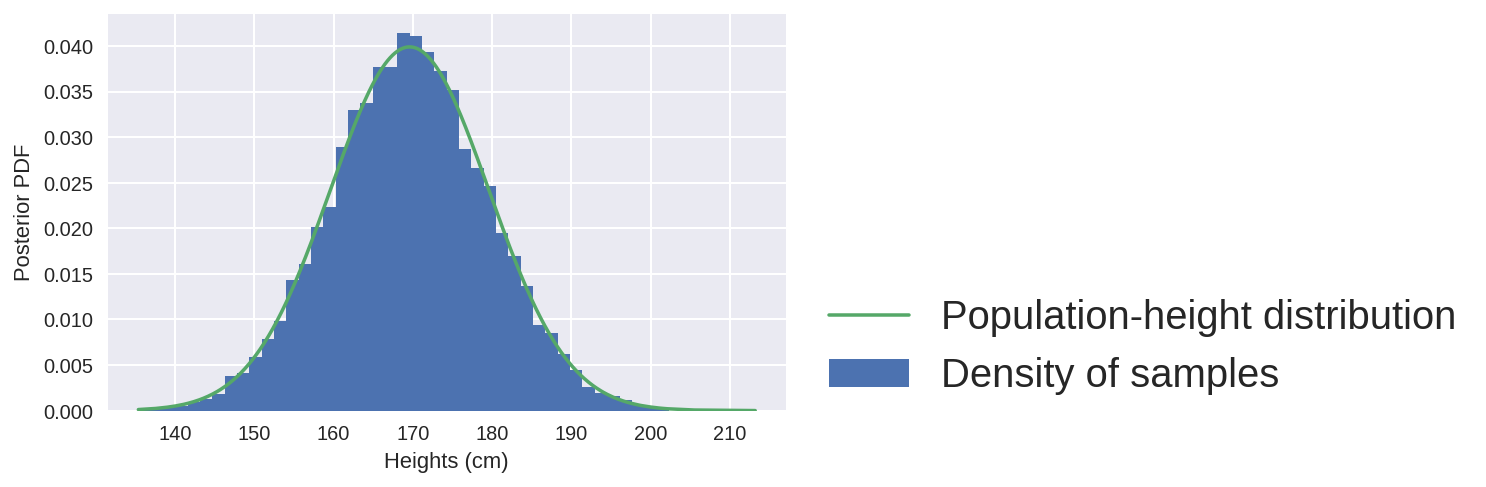

In [2]:
mu_height = 169.6 # average height of people in Chile
sigma_height = 10 # I picked this std deviation at random
heights = np.random.normal(loc=mu_height, scale=sigma_height, size=10000)

heights_sorted = np.sort(heights)
plt.hist(heights, density=True,label='Density of samples',bins=50)
Gaussian_pdf = norm.pdf(heights_sorted, loc=mu_height, scale=sigma_height)
plt.plot(heights_sorted,Gaussian_pdf, label='Population-height distribution')
plt.xlabel('Heights (cm)')
plt.ylabel('Posterior PDF')
plt.legend(loc=(1.04,0),prop={'size': 20})


Finding the underlying population-height distribution in this case is trivial: we just histogram the measurements because the measurements are just points and we have a large number of them.
    * The statistical measurement uncertainty for Gaussian variables scales like the number of measurements $N$ as $1/\sqrt(N)$

Combining probability densities is far more subtle: distributions can be very spread out (large tails); the odds of a 
signal vs noise might be low or near a detection threshold; the "true" parameter values will only be contained within the, e.g., $90\%$ credible interval $90\%$ of the time; etc...

Our best approach is to "embrace" the uncertainty of each measurement becasue we can't do any better! 

In order to formalize population-level inference, we need to refine the question we want to ask of our data and measurements.

# A worked example

Let’s consider a toy problem where we have measured the mass of $200$ exoplanets. For the sake of simplicity, imagine that the data consists of observing single stars, and each star hosts exactly one planet.


---


* Our measurements consist of $200$ posterior PDFs of the planets masses, and together with the signal and noise evidences.


---


* For now, we will assume that we have been given privileged knowledge of the universe, and that we have no false detections (all of our signals came from astrophysical sources). 
    * This is equivalent to saying that the odds ratio for having detected a signal in each case is 1.
    

---


We'll generate some synthetic data below. Our planet-mass distribution will be a $\chi^2$ distribution with 4 degrees of freedom. 

    * Note that this is not physically motivated. It's just a simple distribution that's easy to use in python
    
    


## Generating the **population**

(0, 0.386266967279777)

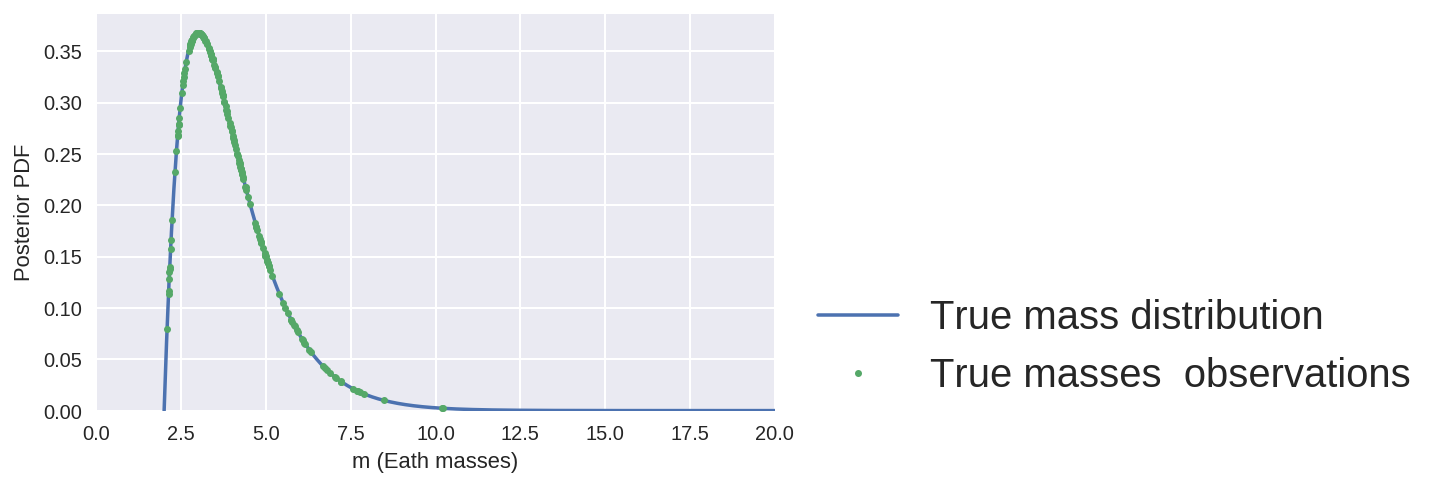

In [3]:
from scipy.stats import chi2

m_min = 2 # This is the (assumed) minimum planet mass (in Earth masses)
m_max = 20 # This is the (assumed) maximum planet mass (in Earth masses)
sigma_true = 0.5 # The variance of the mass distribution
mu_true = m_min # The mean of the mass distribution

m_grid = np.linspace(m_min,m_max,500)

dof = 4

p_of_m = chi2.pdf(m_grid, dof, loc=mu_true, scale=sigma_true)
draws_from_mass = chi2.rvs(dof, loc=mu_true, scale=sigma_true, size=200, random_state=150)

plt.plot(m_grid,p_of_m,label='True mass distribution')
plt.plot(draws_from_mass,chi2.pdf(draws_from_mass, dof, loc=mu_true, scale=sigma_true),\
         marker='.',linestyle='',label='True masses  observations')

plt.legend(loc=(1.04,0),prop={'size': 20})

plt.xlabel('m (Eath masses)')
plt.ylabel('Posterior PDF')
plt.xlim(0, 20)
plt.ylim(0)


The orange draws from the mass distribution will be the "true" values which we will imagine are encoded in a signal that our experiment records. Each signal will assumed to be buried in noise so that we're prevented from making perfect measurements of the masses.

For the toy problem, we'll assume that the planet masses are encoded in a sine-wave time series. Again, this is totally artificial, but it suffices to demonstrate the principle of the hierarchical measurement process, while keeping the complexity to a minimum. Each signal will be embedded in mean-zero, variance-one Gaussian noise. Below, we will generate our 200 synthetic data sets. For each data set, we'll produce a posterior PDF of the planet mass, together with the evidence that the data contain a signal and the evidence that the data are just noise.

### A model for the population

Let's imagine that we know that masses from the population are drawn from the $\chi^2$ distribution, but that we do not know its scale $\sigma$. 

We can construct a population hypothesis $\mathcal{H}_{pop}$ which states


---


$\textbf{Population Hypothesis:}\, \mathcal{H}_{pop}$

* $ \mathcal{H}_{pop}: m\sim\chi^2(4\,\text{d.o.f}, \sigma)  $



---



## Generating our data sets

* We will generate 200 data sets, each containing a signal and noise

  * $d_i(t) = s_i(t) + n_i(t) $ 

In [0]:
timeseries = np.linspace(0,10,10000)


def exoplanet_model(m):
    
    signal = lambda m: 0.001*m*timeseries + 0.55*timeseries**(0.4)
    
    return signal(m)


data_sets = np.zeros((len(draws_from_mass), len(timeseries)))
signal_sets = np.zeros((len(draws_from_mass), len(timeseries)))
noise_sets = np.zeros((len(draws_from_mass), len(timeseries)))

for i,m in enumerate(draws_from_mass):

    np.random.seed(i*213)
    
    sig = exoplanet_model(m)
    noise = np.random.normal(size=len(timeseries),loc=0,scale=1)
    data = sig + noise
    
    data_sets[i] = data
    signal_sets[i] = sig
    noise_sets[i] = noise
    


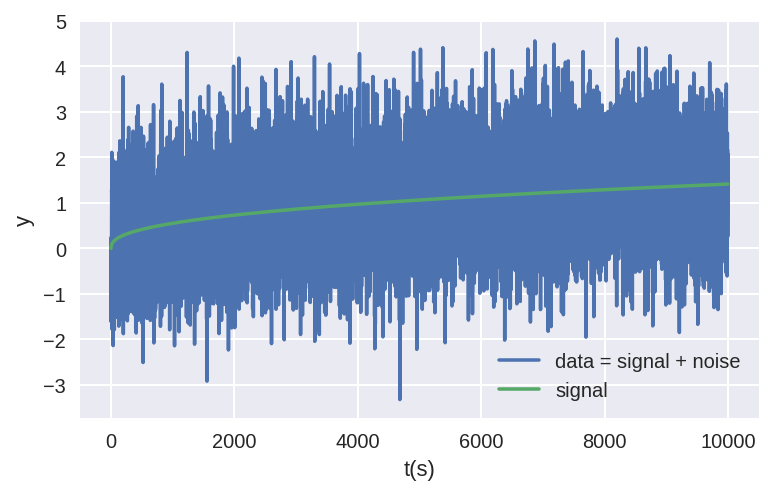

In [7]:
plt.plot(data_sets[44],label="data = signal + noise")
plt.plot(signal_sets[44], label='signal')
plt.xlabel('t(s)')
plt.ylabel('y')
plt.legend()


## Stage 1: Inference on individual data sets and signals

### Our objective in Stage 1

In the hierarchical inference process, we first have to compute posterior PDFs for the mass of each planet, and obtain the evidence that that data contain a signal, and for noise. We'll build upon our work in the previous two lectures to compute the posteriors and evidences. Our signal and noise hypotheses will be essentiall unchanged, apart from the signal model now takes a mass as a parameter. Using Bayes theorem, we want to compute


---


$p(m_i | d_i, \mathcal{H}_S) = \frac{\pi(m_i) \mathcal{L}(d_i|m_i, \mathcal{H}_S)}{Z(d_i|\mathcal{H}_S)}$

and

$Z(d_i|\mathcal{H}_N)$

---


for each of the 200 $d_i$. 

### Our hypotheses in Stage 1

We need to write out our hypotheses, likelihoods and priors. We have two hypotheses: The "signal" hypothesis $\mathcal{H}_S$ and the "noise" hypothesis $\mathcal{H}_N$.


---


$\textbf{Noise Hypothesis}$
* $\mathcal{H}_N: d(t_k) = n(t_k)$

with

* $n(t_k) \sim \mathcal{N}(\mu=0,\sigma=1) \,\forall\, t_k $



---


$\textbf{Signal hypothesis}$: $\mathcal{H}_S$

Under the signal hypothesis, the three assuptions that form our model for the data are 

* $n_i(t_k) \sim \mathcal{N}(\mu=0,\sigma=1)\,\, \forall\,\, t_k$
* $y_{\text{signal}}(t_k;m_i) = 0.001m_it_k + 0.55t_k^{0.4}$ 
* $d_i(t_k) = y_{\text{signal}}(t_k;m_i) + n(t_k)$

Recall that in Lecture 1 we "rephrased" the signal hypothesis by leveraging our knowledge of the noise:

* $\mathcal{H}_S : n_i(t_k) = d_i(t_k) - y_{\text{signal}}(t_k;m_i)$

with

* $n_i(t_k;\mu,\sigma) \sim \mathcal{N}(\mu=0,\sigma=1)\,\, \forall\,\, t_k$


---


This allowed us to write down the probability of the noise, given the data and the model. 


### The likelihood

The likelihood of the residual $d_i(t_k) - y_{\text{signal}}(t_k;m_i)$ can be modelled as a Gaussian

* $\mathcal{L}(d|\theta,\mathcal{H}_S) = \prod_{k}\text{Normal}\Big([d_k - y_{\text{signal}}(m_i)_k], \mu=0, \sigma=1 \Big)$

The product follows from the fact that each data sample $d_k = d(t_k)$ in the data set $d=\{d_1,d_2,...,d_N\}$ are $\textit{iid}$ (indentically and independently distributed. 

To evaluate the posterior, we will need to write down a prior and a likelihood function. 

### The prior 

Starting with the prior, let's assume our usual uniform distribution on each of the four $\textit{a priori}$ unknown mass $m$:

* $\pi(m) = \text{Uniform}(m_{\min},m_{\max})$

This prior distribution is chosen under the assumption that when we signal arrives, we have no $\textit{a priori}$ way of telling what the planet mass will be.

This seems to be in contradiction with the population hypothesis $\mathcal{H}_{pop}$. Why haven't we used $\mathcal{H}_{pop}$?

* We want to let the $\textit{ensemble of measurements to inform us}$
  * The prior hypothesis encompasses many instances of the data; we don't want to decide information about the population from individual measurements

Outside of the ranges specified, the (prior) probabiltiy will assumed to be zero.



### Putting it all together

In [0]:
def logL_signal(data, signal_model, m):

        signal_m = signal_model(m)
        
        log_L = np.sum( norm.logpdf(data-signal_m, loc=0, scale=1) )
    
        return log_L

def log_prior_m(m):
    log_prior = stats.uniform.logpdf(m, loc=m_min,scale=m_max)
    
    return log_prior
    
    
def log_evidence(log_posterior, m_grid):
    
    dm = m_grid[1]-m_grid[0]#integration element
    lnZ = logsumexp(log_posterior,b=dm)
    return lnZ



We'll now compute the posteirors


                                                               
                                                               

In [0]:
log_p_given_m = np.zeros((len(data_sets), len(m_grid)))
lnZs_signal = np.zeros(len(data_sets))
lnZs_noise = np.zeros(len(data_sets))
 
# compute the posterior PDF on m given each data set, and the evidence:    
    
for i, d in enumerate(data_sets):
    
    for k, m in enumerate(m_grid):
        
        
        log_l = logL_signal(d, exoplanet_model, m)
        
        log_pi = log_prior_m(m)
        
        log_p_given_m[i][k] = log_pi + log_l
                 
    lnZs_signal[i] = log_evidence(log_p_given_m[i], m_grid)
    lnZs_noise[i] = np.sum(norm.logpdf(d,loc=0, scale=1))
    # normalize the posterior 
    log_p_given_m[i] -= lnZs_signal[i]


(0, 0.24489233000988095)

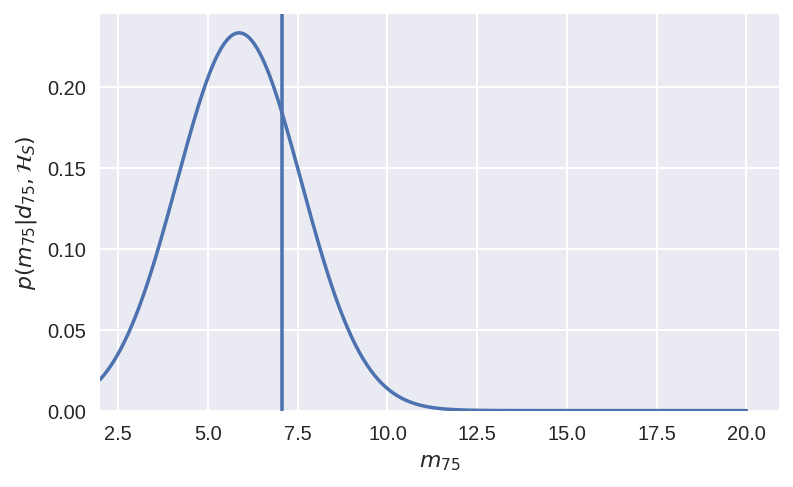

In [10]:
plt.plot(m_grid, np.exp(log_p_given_m[75]))
plt.axvline(draws_from_mass[75])
plt.xlabel('$m_{75}$')
plt.ylabel('$p(m_{75}|d_{75},\mathcal{H}_S)$')
plt.xlim(m_min)
plt.ylim(0)

## Stage 2 : Population-level inference

Having obtained our 200 PDFs, and 200 signal and noise evidences, we can proceed to stage two of the hierarchical inference process, in which we want to learning about the underlying mass distribution $p(m)$.

We will assume that we know that the underlying distribution is a $\chi^2$ distribution with 4 d.o.f., and that we know the mean $\mu$ but not the scale $\sigma$. In this case, we are introducing a "hyperparameter" $\sigma$ which we would like to measure. In this case, $\sigma$ encodes all of our uncertainty about the population distribution, though in general, more complex models can be constructed. In the language of Bayesian inference, we would like to compute the posterior PDF on $\sigma$ conditional on all of the data we have collected and analyzed. Formally, we are trying to arrive at




---


* $ p(\sigma | \{d_i\}_{i=1}^{200},\mathcal{H_s},\mathcal{H}_{pop})$
    * Where $\{d_i\}_{i=1}^{200}$ means the 200 data sets, each of which contains a signal.

* This is called the $\textbf{Hyper Posterior}$
---




We can write out the RHS of $ p(\sigma | \{d_i\},\mathcal{H_s},\mathcal{H}_{pop})$ using Bayes Theorem:

* $ p(\sigma | \{d_i\},\mathcal{H_s},\mathcal{H}_{pop}) = \frac{\pi(\sigma)\mathcal{L}(\{d_i\}|\sigma,\mathcal{H_s},\mathcal{H}_{pop})}{Z(\{d_i\}|\mathcal{H_s},\mathcal{H}_{pop})}  $

Notice that on the RHS, we have a new likelihood, prior and evidence:


---


* $\pi(\sigma)$ is the $\textbf{prior}$
* $\mathcal{L}(\{d_i\}|\sigma,\mathcal{H_s},\mathcal{H}_{pop})$ is called the $\textbf{hyper likelihood}$
* $Z(\{d_i\}|\mathcal{H_s},\mathcal{H}_{pop})$ is called the $\textbf{population evidence}$


---




Ignoring the population evidence for now, our two challenges are to write down the hyper likelihood and prior. We will assume that we can easily pick a suitable prior $\pi(\sigma)$. 

How then shall we write down the hyper likelihood? There are two steps. Firstly, we want to be able to use the information which we aquired in Stage 1, namely the likelihoods, posteriors and evidences. One candidate ingredient, therefore could be 
$\Big[\mathcal{L}(d_i|m_i, \mathcal{H_s},\mathcal{H}_{pop})\Big]$. 
    * Notice that this candidate features a likelihood, rather than a posterior. This makes it slightly easier to make an "apples to apples" equation between likelihoods
    
Let's assume for now that $\mathcal{L}(d_i|\sigma,\mathcal{H_s},\mathcal{H}_{pop})$ is a $\textit{functional}$ of $\mathcal{L}(d_i|m_i, \mathcal{H}_S)$, i.e., 

* $\mathcal{L}(d_i|\sigma,\mathcal{H_s},\mathcal{H}_{pop}) = F\Big[\sigma; \mathcal{L}(d_i|m_i, \mathcal{H}_S)\Big]$

The LHS is just a function of $\sigma$ and the likelihood $\mathcal{L}(d_i|m_i, \mathcal{H}_S)$ does not depend on $\sigma$. We somehow have to introduce a dependence between the likelihood and the hyperparameter. 

To do this, let's go back to the original question we're trying to answer, namely, what is the mass distribution? Because we don't know the scale $\sigma$ what we're really asking what is the probability of obtaining a mass $m$, $\textit{conditional on}$ $\sigma$. In otherwords, we have a $\textbf{hyper prior}$ distribution 

* $\pi(m|\sigma)$ which encodes our prior belief about the underlying mass distribution, conditional on the hyperparameter $\sigma$.



Returning to the hyper likeliehood: We can use the hyper prior $\pi(m|\sigma)$ together with the "trick" of marginalization to write out the RHS of $\mathcal{L}(d_i|\sigma,\mathcal{H_s},\mathcal{H}_{pop})$. Notice that the following is true in general:


---


* $\mathcal{L}(d_i|\sigma,\mathcal{H_s},\mathcal{H}_{pop}) = \int dm_i \, \mathcal{L}(d_i|m_i, \mathcal{H}_S)\,\pi(m_i|\sigma,\mathcal{H}_{pop})$


---




In otherwords, the hyper likelihood is the result of marginalizing the likelihood function over mass, weighted by a hyper prior that's conditional on the hyper parameter: This is what links $m$ with $\sigma$.

We can recast the integrand in terms of the posterior, prior and evidence using simple algebra:


---


${\cal L}(d | \sigma, \mathcal{H}_S,\mathcal{H}_{pop}) =  \int d m_i \, 
p(m_i | d_i, \mathcal{H}_S) \, {\cal Z}(d_i|\mathcal{H}_S) \,
\frac{\pi(m_i | \sigma,\mathcal{H}_{pop})}{\pi(m_i)} .
$


---


This is just for one data set $d$. The hyper likelihood for the $\textit{set}$ of data sets is just a product of hyper likelihoods:

* ${\cal L}(\{d\} | \sigma, \mathcal{H}_S,\mathcal{H}_{pop}) =  \prod_i \int d m_i \, 
p(m_i | d_i, \mathcal{H}_S) \, {\cal Z}(d_i|\mathcal{H}_S) \,
\frac{\pi(m_i | \sigma,\mathcal{H}_{pop})}{\pi(m_i)}\,,
$

which follows from the independence of the data sets.



### Our objective in Stage 2

$\textbf{Our objective is the compute the posterior distribution on the hyper parmaeter}\, \sigma$ 

* $ p(\sigma | \{d_i\},\mathcal{H}_S,\mathcal{H}_{pop}) = \frac{\pi(\sigma)\mathcal{L}(\{d_i\}|\sigma,\mathcal{H}_S,\mathcal{H}_{pop})}{Z(\{d_i\}|\mathcal{H}_S,\mathcal{H}_{pop})}  $

We now have a way to write down the likelihood of $\textit{all of our data sets}$ given a hyper parameter of the population parameter $\sigma$ (which we can think of as a parameter which informs our prior belief)

* ${\cal L}(\{d\} | \sigma, \mathcal{H}_S,\mathcal{H}_{pop}) =  \prod_i \int d m_i \, 
p(m_i | d_i, \mathcal{H}_S) \, {\cal Z}(d_i|\mathcal{H}_S) \,
\frac{\pi(m_i | \sigma,\mathcal{H}_{pop})}{\pi(m_i)}\,,
$

With the likleihood we have almost everything we need to compute a posterior on $\sigma$





We need to write out the 

* hyper prior $\pi(m_i | \sigma,\mathcal{H}_{pop})$

* the prior on $\sigma$: $\pi(\sigma)$



### The hyper prior: $\pi(m_i | \sigma,\mathcal{H}_{pop})$

We will finally use the "population hypothesis" $\mathcal{H}_{pop}$

Recall that we defined $\mathcal{H}_{pop}$ as

$ \mathcal{H}_{pop}: m\sim\chi^2(4\,\text{d.o.f}, \sigma)  $

This gives us a functional form for the hyper prior:

$\pi(m_i | \sigma,\mathcal{H}_{pop}) = \chi^2_{\text{PDF}}(4\,\text{d.o.f},\sigma)$

### The prior


For now we'll just assume the usual uniform distribution on $\sigma$ as a way of encoding our lack of $\textit{a priori}$ preference for any particular value. Let's assume that the range of possible $\sigma$ are

* $\sigma \in \Big[0.1,20\Big]$

and

* $\pi(\sigma) = \text{Uniform}(0.1, 20)$



### Putting it all together: Computing the hyper posterior

In [0]:
### perform hyper PE

# define the hyper prior

sigma_min = 0.1
sigma_max = 20
sigmas = np.linspace(sigma_min,sigma_max,1000)

dm = m_grid[1]-m_grid[0] # this is the integration element for the integral over m
 
def log_prior_sigma(sigma):
    
    log_prior = stats.uniform.logpdf(sigma, loc=sigma_min, scale=sigma_max)

    return log_prior


def log_hyperprior(m,sigma):
    
    log_prior = stats.chi2.logpdf(m, dof, loc=mu_true, scale=sigma)

    return log_prior


def log_hyperlikelihood(data_sets,sigma):
    
    for i, d in enumerate(data_sets):
        
        log_hyper_prior = log_hyperprior(m_grid,sigma)
        log_old_prior =  log_prior_m(m_grid)
        log_posterior = log_p_given_m[i]
        log_signal_evidence = lnZs_signal[i]
        
        _log_l_of_m_sigma = log_posterior + log_signal_evidence\
                    + (log_hyper_prior-log_old_prior) # this is the integrand
        _log_l_of_sigma = logsumexp(_log_l_of_m_sigma,b=dm) # hyper likelihood for one data set

        if i == 0:
        
            log_hyper_L = _log_l_of_sigma # sum over data sets
        else:
            log_hyper_L += _log_l_of_sigma # sum over data sets
            
    return log_hyper_L
            
log_hyper_posterior = np.zeros(len(sigmas))

for j, sigma in enumerate(sigmas):

    log_hyper_posterior[j] = log_hyperlikelihood(data_sets,sigma) + log_prior_sigma(sigma)

(0, 0.20862992611563372)

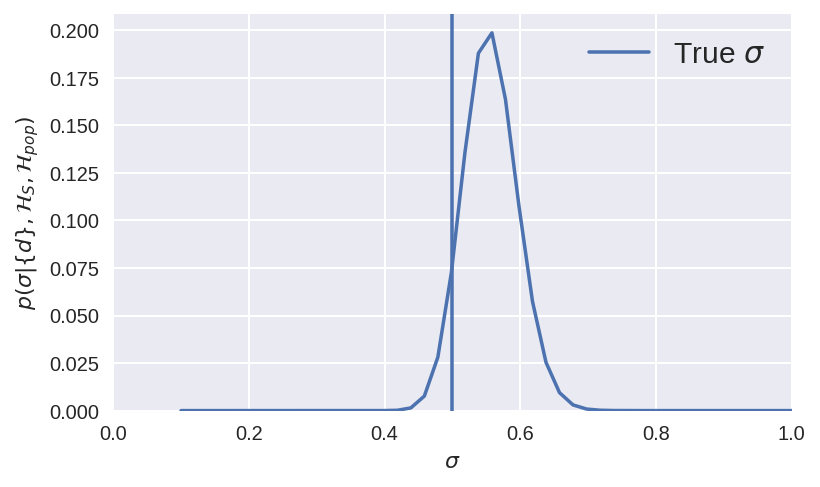

In [0]:
reg = np.max(log_hyper_posterior)
hyper_post = np.exp(log_hyper_posterior-reg) / np.sum(np.exp(log_hyper_posterior-reg) )
plt.plot(sigmas, hyper_post)
plt.axvline(sigma_true,label='True $\sigma$')
plt.xlabel('$\sigma$')
plt.ylabel('$p(\sigma|\{d\},\mathcal{H}_S,\mathcal{H}_{pop})$')
plt.legend(prop={'size': 15},loc=1)
plt.xlim(0,1)
plt.ylim(0)

#plt.savefig("images/hyper_posterior.pdf", format='pdf',bbox_inches='tight',dpi=100)


## How to handle posterior samples in hierarchical inference

It is useful to consider what happens when we don't have $\textit{exact}$ representations of the posterior, or evidences, i.e., if we're given posterior $\textit{samples}$:

* $\{m_i^k\}_{(i,k)=(1,1)}^{(N,M)}$. 
    * Here $i$ indexes a data set
    * k indexes a posterior sample

In this case, the hyper likelihood is simply a ratio of priors, summed over posterior samples:

* ${\cal L}(d | \sigma,\mathcal{H}_S,\mathcal{H}_{pop}) = \prod_i^N
\frac{{\cal Z}(d_i|\mathcal{H}_S)}{n_i}
\sum_k^{n_i} \frac{\pi(m^k_i|\sigma,\mathcal{H}_{pop})}{\pi(m^k_i)} 
$

The sum follows from the density of sample points, similar to a numerical average.


